
## Linear Regression Bagging

#### Sebastian Prez
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Ademidé Mabadeje, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/ademidemabadeje/)


### Executive Summary

Boostrap aggregation, or bagging, is a method generally used in prediction methods that tend to overfit the training data. Thus, bagging is very useful with low-bias, high-variance models. Linear regression, on the other hand, is a relatively high-bias and low variance method. The goal of this workflow is to evaluate the impact of uncertainty on the variance of a linear regression model by bagging the training data. A plot of the r2 score (variance explained) and the mean squared error (MSE) is used to determine if and how the model variance changes with the number of bootstrap realizations. Small improvements are sometimes observed with a relatively low number of bootstrap realizations, which likely due to using a "modified" dataset; and even then, no change is detected after 100 realizations or so. The overall results show that bootstrapping the training data does not significantly affect the variance of a linear regression model.

Going forward, I recommend exploring this phenomenon with different datasets. It would be useful to see how the data itself and the size of the dataset affect the results shown in this workflow. This was beyond the scope of this project due to length and time constraints.


### Import Packages

In [1]:
import numpy as np                                          # arrays and matrix math
import pandas as pd                                         # DataFrames
import pandas.plotting as pd_plot
import matplotlib.pyplot as plt                             # for plotting
from sklearn.metrics import mean_squared_error, r2_score    # specific measures to check our models
from sklearn import linear_model                            # linear regression model
from sklearn.model_selection import train_test_split        # train and test split
import random                                               # used to perform bootstrap manually

### Load Data

The following workflow applies the CSV file 'Density_Por_data.csv', a synthetic yet realistic dataset created by Dr. Michael Pyrcz, which can be found on his Github repository [here](https://github.com/GeostatsGuy/GeoDataSets). This dataset was chosen because it has a good linear relationship, which is useful to properly assess the findings of this project.

We will work with the following features:

* **Density** - weight of the rock in grams divided by its volume in cubic centimeters (g/cc).
* **Porosity** - rock void space over bulk volume (void + solids) as a percentage.

In [2]:
my_data = pd.read_csv("https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/Density_Por_data.csv") # load from Prof. Pyrcz's GitHub

We display the first few rows of the dataframe to check it was loaded properly.

In [3]:
my_data.head()

,Density,Porosity
0,1.281391,16.610982
1,1.404932,13.668073
2,2.346926,9.590092
3,1.348847,15.877907
4,2.331653,4.968240


### Summary Statistics for Tabular Data
Below is a quick summary of statistics for the dataset. This serves as a quick quality check of the data.

In [4]:
my_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Density,105.0,1.737917,0.288278,0.996736,1.552713,1.748788,1.906634,2.410560
Porosity,105.0,12.531279,3.132269,4.966421,10.546483,12.411608,14.230930,20.964941


Because we want to evaluate the impact of bootstrapping the training data in this workflow, we will work with a subset of about 60 samples, which we will select at random.

In [5]:
my_data_subset = my_data.sample(frac = 0.6, random_state=1)   # samples a fraction of the data without replacement, unless specified.
por = my_data_subset['Porosity']; density = my_data_subset['Density']
my_data_subset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Density,63.0,1.777852,0.262494,1.257021,1.587645,1.748788,1.891934,2.410560
Porosity,63.0,12.127930,2.836517,4.966421,10.307675,12.258592,13.991371,19.600717


### Test-train split
Now we will split out dataset into a training dataset and a testing dataset. I will a 70/30 split,

In [6]:
x_train, x_test, y_train, y_test = train_test_split(density, por, test_size=0.30, random_state=73073)
y_train = pd.DataFrame({'Porosity':y_train.values})
y_test = pd.DataFrame({'Porosity':y_test.values})

### Visualizing the training and testing data. 
It is useful to see how the training data looks relative to the testing data. This also serves as a quality check to make sure that our train-test split was done properly.

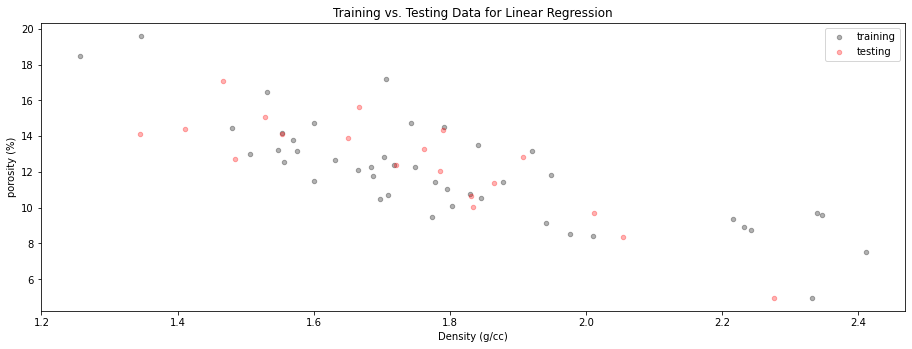

In [7]:
plt.subplot(111)
plt.scatter(x_train, y_train,  color='black', s = 20, alpha = 0.3, label = 'training')
plt.scatter(x_test, y_test,  color='red', s = 20, alpha = 0.3, label = 'testing')
plt.title('Training vs. Testing Data for Linear Regression'); plt.xlabel('Density (g/cc)'); plt.ylabel('porosity (%)')
plt.legend()
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.show()

### Linear regression without bootstrapping the training data

We will now fit a linear regression model to the training data and make predictions. The results of this model will serve as a base to assess the impact of bagging the training data in the subsequent linear regression models.

We will plot the model and the predictions, along with the r2 score and the MSE.

* The code used in the blocks below was taken from Professor Michael Pyrcz (@GeostatsGuy) in collaboration with Midé Mabadeje. Most of the code has been modified.
(https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_PCA.ipynb)

Variance explained: 0.68843
MSE: 2.373


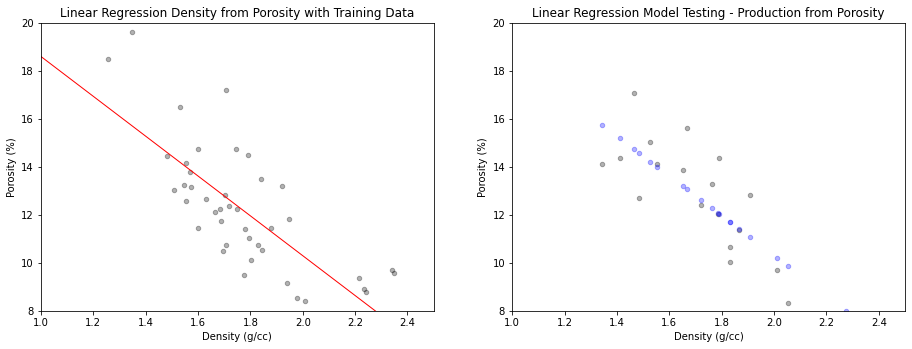

In [8]:
# Step 1. Instantiate the Model 
linear_reg = linear_model.LinearRegression()

# Step 2: Fit the model on Training Data
linear_reg.fit(x_train.values.reshape(-1,1), y_train) # fit model
density_model = np.linspace(1,2.5,len(x_train)) # create x values for a visual representation of the model

# Print the model parameters
porosity_model = linear_reg.predict(density_model.reshape(-1,1)) # predict with the fit model 

# Step 3: - Make predictions using the testing dataset
y_pred = linear_reg.predict(x_test.values.reshape(-1,1))

# Report the goodness of fit
print('Variance explained: %.5f' % r2_score(y_test.values, y_pred))
print('MSE: ' + str(round(mean_squared_error(y_test.values, y_pred), 3)))

# Plot model fit
plt.subplot(121)
plt.scatter(x_train, y_train,  color='black', s = 20, alpha = 0.3)
plt.plot(density_model,porosity_model, color='red', linewidth=1)
plt.title('Linear Regression Density from Porosity with Training Data'); plt.xlabel('Density (g/cc)'); plt.ylabel('Porosity (%)')
plt.xlim(1,2.5); plt.ylim(8,20)

# Plot model predictions 
plt.subplot(122)
plt.scatter(x_test, y_test,  color='black', s = 20, alpha = 0.3)
plt.scatter(x_test, y_pred, color='blue', s = 20, alpha = 0.3)
plt.title('Linear Regression Model Testing - Production from Porosity'); plt.xlabel('Density (g/cc)'); plt.ylabel('Porosity (%)')
plt.xlim(1,2.5); plt.ylim(8,20)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.show()

Before proceeding, we will add the X and Y training data to a dataframe called df_train. This will make the subsequent steps easier.

In [9]:
df_train = pd.DataFrame()
df_train['Density'] = x_train.values
df_train['Por'] = y_train
df_train.head()

,Density,Por
0,1.778580,11.426343
1,1.547463,13.234917
2,1.802992,10.120258
3,1.774021,9.489298
4,1.697005,10.495092


### Linear regression with bootstrapping of the training data

Now, we will bootstrap the training data and assess the impact on model variance by comparing it to the previous results. We will start with 50 realizations.

Variance explained: 0.68764
MSE: 2.379


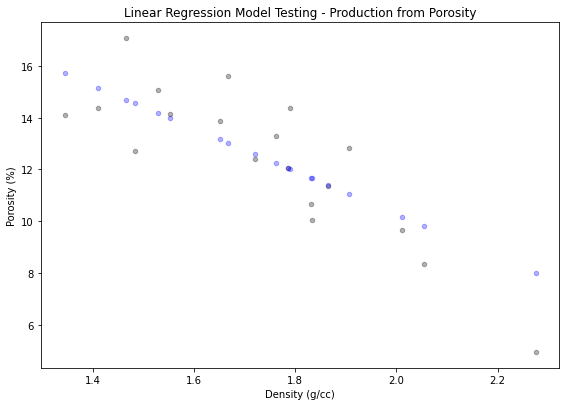

In [10]:
import warnings
warnings.filterwarnings('ignore')                           # suppress warnings

B = 50                               # number of bootstrap realizations                            
df_pred = pd.DataFrame()
df_pred['y_test'] = y_test
df_samples = pd.DataFrame()

for b in range(0,B):
    df_samples = df_train.sample(n=len(df_train), replace=True)                    # sample with replacement from training dataset
    linear_regr = linear_model.LinearRegression()                                  # instantiate the model
    linear_regr.fit(df_samples['Density'].values.reshape(-1,1), df_samples['Por']) # fit model
    y_preds = linear_regr.predict(x_test.values.reshape(-1,1))                     # make predictions
    df_pred['pred_' + str(b)] = y_preds
    
df_pred['final_pred'] = df_pred.iloc[:,1:].mean(axis=1)

# Report the goodness of fit
print('Variance explained: %.5f' % r2_score(y_test.values, df_pred['final_pred'].values.reshape(-1,1)))
print('MSE: ' + str(round(mean_squared_error(y_test.values, df_pred['final_pred'].values.reshape(-1,1)),3)))

# Plot model predictions 
plt.subplot(111)
plt.scatter(x_test, y_test,  color='black', s = 20, alpha = 0.3)
plt.scatter(x_test, df_pred['final_pred'], color='blue', s = 20, alpha = 0.3)
plt.title('Linear Regression Model Testing - Production from Porosity'); plt.xlabel('Density (g/cc)'); plt.ylabel('Porosity (%)')
#plt.xlim(7,23); plt.ylim(0.5,2.5)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

### Results

Comparing the r2 score and MSE to the previous results, we can see that they have barely changed. The variance explained requires at least 3 decimals before we observe any change, and even then, the change is not significant. Thus, bootstrapping the training data seems to have no meaningful impact on model variance.

Now, we will determine if and how the variance of the model changes as the number of bootstrap realizations becomes larger. We will plot the variance explained and the MSE vs. the number of bootstrap realizations. The block below should take a few seconds to run.

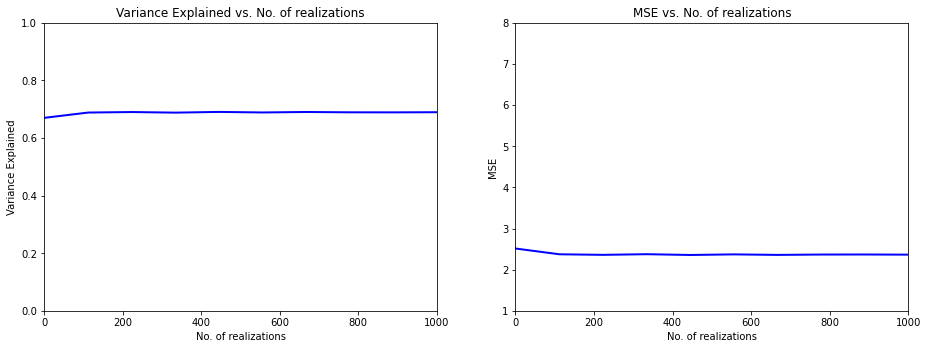

In [11]:
ncases = 10                             # number of cases (items) in the bootstrap realizations matrix
real_mat = np.linspace(1,1000, ncases)  # matrix with number of bootstrap realizations
var_explained_mat = np.zeros(ncases)
MSE_mat = np.zeros(ncases)

for i in range(0, len(real_mat)):
    df_pred = pd.DataFrame()
    df_pred['y_test'] = y_test
    df_samples = pd.DataFrame()

    for b in range(0,int(real_mat[i])):
        df_samples = df_train.sample(n=len(df_train), replace=True)                    # sample with replacement from training dataset
        linear_regr = linear_model.LinearRegression()                                  # instantiate the model
        linear_regr.fit(df_samples['Density'].values.reshape(-1,1), df_samples['Por']) # fit model
        y_preds = linear_regr.predict(x_test.values.reshape(-1,1))                     # make predictions
        df_pred['pred_' + str(b)] = y_preds                                            # save predictions to a dataframe
    
    df_pred['final_pred'] = df_pred.iloc[:,1:].mean(axis=1)                            # aggregate all predictions
    var_explained_mat[i] = r2_score(y_test.values, df_pred['final_pred'].values.reshape(-1,1))  # calculate r2 score
    MSE_mat[i] = mean_squared_error(y_test.values, df_pred['final_pred'].values.reshape(-1,1))  # calculate MSE

plt.subplot(121)
plt.plot(real_mat, var_explained_mat,  color='blue', linewidth = 2, label = 'Training')
plt.title('Variance Explained vs. No. of realizations'); plt.xlabel('No. of realizations'); plt.ylabel('Variance Explained')
plt.xlim(0.,1000.0); plt.ylim(0,1.0)

plt.subplot(122)
plt.plot(real_mat, MSE_mat,  color='blue', linewidth = 2, label = 'Training')
plt.title('MSE vs. No. of realizations'); plt.xlabel('No. of realizations'); plt.ylabel('MSE')
plt.xlim(0.,1000.0); plt.ylim(1,8)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.show()

We can see that there is no significant change in the model variance due to bootstrapping of the training data. There is some very slight improvement before 100 realizations, which is likely due to using "modified' datasets obtained from the realizations. However, there is no improvement beyond 100 realizations.

I hope this was helpful,

Sebastian

___________________
#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)